In [1]:
import os
import codecs
from docx import *
import docx2txt
from PIL import Image
from wand.image import Image as IMG
import pytesseract
import textract

def get_string(name):
    img=Image.open(name)
    utf8_text = pytesseract.image_to_string(img)
    utf8_text = str(utf8_text.encode('ascii', 'ignore'))
    return utf8_text

data_dir = os.path.join('Resumes')
resume_count = 0
resume_text = "all_text1.txt"
if 1==0:
    with codecs.open(resume_text,'w',encoding='utf_8') as resume_txt:
        for filename in os.listdir(data_dir):
            s = ""
            #use doc2txt plugin for word files
            if filename.endswith(".docx"):
                location = str(os.path.join(data_dir,filename))
                #document = Document(location)
                #for paragraph in document.paragraphs:
                #    s += str(paragraph.text.encode(errors='ignore'))
                s = docx2txt.process(location)
                resume_txt.write(s+'\\n'+'\n')
                resume_count += 1
            
            #if textract cant extract a pdf we then turn it to an img and then convert that instead
            elif filename.endswith(".pdf"):
                utf8_text = ""

                temp_doc = textract.process(os.path.join(data_dir,filename))
                if len(temp_doc) < 50:
                    img=IMG(filename=os.path.join(data_dir,filename),resolution=200)

                    img.save(filename=os.path.join(data_dir,'temp','temp.jpg'))
                    for files in os.listdir(os.path.join(data_dir,'temp')):
                        utf8_text += get_string(os.path.join(data_dir,'temp',files))
                    for files in os.listdir(os.path.join(data_dir,'temp')):
                        os.remove(os.path.join(data_dir,'temp',files))
                    temp_doc = utf8_text

                if type(temp_doc)==str:
                    resume_txt.write(temp_doc+'\\n'+'\n')    
                else:
                    resume_txt.write(temp_doc.decode("utf-8")+'\\n'+'\n')    
                resume_count +=1
                
print(resume_count)

413


This reads in the all the resumes in as strings to be used to train the machine learning off of

In [2]:
import spacy
import pandas as pd
import itertools as it

nlp = spacy.load('en')

/home/jared/Parsing/parseVirt/lib/python3.5/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.21.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
with codecs.open(resume_text,encoding="utf_8") as f:
    sample_res = list(it.islice(f,8,9))[0]
    sample_res = sample_res.replace('\\n','\n')
print(sample_res)  

• B.S. Physiology and Neurobiology



In [4]:
parsed_res_sample = nlp(sample_res)
print(parsed_res_sample)

• B.S. Physiology and Neurobiology



In [5]:
for num,entity in enumerate(parsed_res_sample):
    print("Entity",entity, '-',entity.ent_type_)

Entity • - 
Entity B.S. - PERSON
Entity Physiology - PERSON
Entity and - 
Entity Neurobiology - 
Entity 
 - 


NLP can be used to mark words for extra information like what type of word it is however it is not super accurate

In [6]:
token_text = [token.orth_ for token in parsed_res_sample]
token_lemma = [token.lemma_ for token in parsed_res_sample]
token_shape = [token.shape_ for token in parsed_res_sample]
d = list(zip(token_text,token_lemma,token_shape))
pd.DataFrame(data =d,\
            columns=['token_text','token_lemma','token_shape'])


,token_text,token_lemma,token_shape
0,•,•,•
1,B.S.,b.s.,X.X.
2,Physiology,physiology,Xxxxx
3,and,and,xxx
4,Neurobiology,neurobiology,Xxxxx
5,\n,\n,\n


In [7]:
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

def punct_space(token):
    "helper that elimates puncations and whitespace"
    return token.is_punct or token.is_space

def line_review(filename):
    "read resumes from the file and un-escapes orignal line break"
    with codecs.open(filename,encoding='utf_8') as f:
        for res in f:
            yield res.replace('\\n','\n')
 
def lemmatized_sentence_corpus(filename):
    "use spacy to parse, lemmatize and yield sentences"
    for parsed_res in nlp.pipe(line_review(filename),batch_size=10000,n_threads=3):
        for sent in parsed_res.sents:
            yield u' '.join([token.lemma_ for token in sent if not punct_space(token)])
            


In [8]:
unigram_filepath = 'unigram_sentences.txt'

In [9]:
with codecs.open(unigram_filepath,'w',encoding='utf_8') as f:
    for sent in lemmatized_sentence_corpus(resume_text):
        f.write(sent+'\n')

In [10]:
#Phrases combines words like college park which is two seperate words becomes college_park one word which can then
#be extracted as a combination

normal_res = LineSentence(unigram_filepath)
bigram_sentence = ''
normal_res2 = Phrases(normal_res)
with codecs.open('bigram.txt', 'w', encoding='utf_8') as f:
    for unigram_sentence in normal_res:        
        bigram_sentence =  ' '.join(normal_res2[unigram_sentence])
        f.write(bigram_sentence+'\n')
        


/home/jared/Parsing/parseVirt/lib/python3.5/site-packages/gensim/models/phrases.py:274: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [11]:
#Trigram is the same but it will combine three word phrases now
bigram_sentences = LineSentence('bigram.txt')

trigram_model = Phrases(bigram_sentences)
with codecs.open('trigram.txt', 'w', encoding='utf_8') as f:
    for unigram_sentence in bigram_sentences:        
        trigram_sentence =  ' '.join(trigram_model[unigram_sentence])
        f.write(trigram_sentence+'\n')
        
normal_res1 = LineSentence('trigram.txt')



/home/jared/Parsing/parseVirt/lib/python3.5/site-packages/gensim/models/phrases.py:274: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Word2Vec is a tool that uses a mix of machine learning tools to put words into a vector of your size.  This puts words that show up next to each other closer together in this high dimesional space.  This is useful for skill extraction becuase other skills will show up next to each other more then other words which we hope will group them together.  The window is how far out the model will calculate similar words

In [12]:
from gensim.models import Word2Vec
word2vec_file = "vector_models"

In [13]:
#set true if you want to create the word2vec model workers is how many corees it runs and min count means
#a word has to show p at elast 5 times to be added to the model
if 1==0:
    res2vec = Word2Vec(normal_res,size=300,window=10,sg=1,workers=4,min_count=5)
    res2vec.save(word2vec_file)

    for i in range(1,15):
        res2vec.train(normal_res,total_examples=res2vec.corpus_count, epochs=res2vec.iter)
        res2vec.save(word2vec_file)
    
res2vec = Word2Vec.load(word2vec_file)
res2vec.init_sims()

In [14]:
#heres the word 2vec model in a pandas datafram
ordered = [(term,voc.index,voc.count)for term, voc in res2vec.wv.vocab.items()]
ordered_terms,term_indices,term_count = zip(*ordered)
word_vectors = pd.DataFrame(res2vec.wv.syn0[term_indices,:],index=ordered_terms)

word_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
realm,-0.360408,0.029284,-0.115544,-1.053952,-0.841916,0.286495,-0.042295,-0.451604,-0.275087,0.323954,...,-0.177710,0.093284,-0.069355,0.156493,0.289924,0.160878,0.040892,-0.446672,-0.137130,0.028536
quarter,0.113264,-0.126455,0.831454,0.362539,1.445431,0.208733,0.161270,-0.322154,0.079035,0.193660,...,-0.318822,0.143735,0.646976,-0.110608,0.738265,-0.052204,0.088215,0.147583,-0.683199,-0.122661
odessa,-0.138144,0.254932,0.421352,-0.059983,-0.332860,0.424415,-0.182144,0.118750,-0.149488,0.096808,...,0.255728,-0.092979,-0.241962,-0.139552,0.269532,0.166828,-0.150516,-0.294787,0.251511,0.126374
10/16,0.003950,-0.698829,0.411640,-0.561582,-0.610219,0.347317,0.266754,0.346092,0.378322,0.148405,...,-0.009086,-0.269663,0.198068,-0.367329,-0.343018,-0.108510,-0.366100,-0.031014,0.106402,0.286522
tracer,-0.007786,-0.360372,0.130724,0.094490,-0.267751,0.092034,0.723533,-0.511982,0.082928,0.401027,...,-0.810954,0.181702,0.276747,-0.675465,0.202505,-0.260437,-0.685534,-0.404403,0.381943,-0.960496


In [15]:
#this shows the probality you will see the word java in the window of of the word python
res2vec.n_similarity(['python'],['java'])

0.27475053289729667

In [16]:
#this prints the top 10 similar words to a token
def get_related_terms(token,topn=10):
    "get the top n most similar terms"
    for word,similar in res2vec.wv.most_similar(positive = [token],topn=topn):
        print(word,':',round(similar,3))

In [17]:
get_related_terms('python')

3-sectored : 0.438
verilog : 0.421
bash : 0.402
languag : 0.387
ocaml : 0.374
languages : 0.369
html5 : 0.368
palisade : 0.366
stattools : 0.365
precisiontree : 0.363


In [18]:
get_related_terms('java')

j2me : 0.5
j2ee : 0.453
jsp : 0.432
j2se : 0.431
swings : 0.426
taglibs : 0.425
applets : 0.41
1.4 : 0.408
jdk1.6 : 0.395
html : 0.394


Because you can't visualize 300 dimensional space we use TNSE which will compact the vectors into x and y cordinates which we can then use to plot the points

In [19]:
from sklearn.manifold import TSNE
import _pickle as pickle

tsne_input = word_vectors.drop(spacy.en.English.Defaults.stop_words,errors='ignore')
tsne_input.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
realm,-0.360408,0.029284,-0.115544,-1.053952,-0.841916,0.286495,-0.042295,-0.451604,-0.275087,0.323954,...,-0.177710,0.093284,-0.069355,0.156493,0.289924,0.160878,0.040892,-0.446672,-0.137130,0.028536
quarter,0.113264,-0.126455,0.831454,0.362539,1.445431,0.208733,0.161270,-0.322154,0.079035,0.193660,...,-0.318822,0.143735,0.646976,-0.110608,0.738265,-0.052204,0.088215,0.147583,-0.683199,-0.122661
odessa,-0.138144,0.254932,0.421352,-0.059983,-0.332860,0.424415,-0.182144,0.118750,-0.149488,0.096808,...,0.255728,-0.092979,-0.241962,-0.139552,0.269532,0.166828,-0.150516,-0.294787,0.251511,0.126374
10/16,0.003950,-0.698829,0.411640,-0.561582,-0.610219,0.347317,0.266754,0.346092,0.378322,0.148405,...,-0.009086,-0.269663,0.198068,-0.367329,-0.343018,-0.108510,-0.366100,-0.031014,0.106402,0.286522
tracer,-0.007786,-0.360372,0.130724,0.094490,-0.267751,0.092034,0.723533,-0.511982,0.082928,0.401027,...,-0.810954,0.181702,0.276747,-0.675465,0.202505,-0.260437,-0.685534,-0.404403,0.381943,-0.960496


In [20]:
tsne_file = 'tsne_models'
tsne_vectors_file = 'tsne_vectors.npy'

In [21]:
tsne = TSNE()
tnse_vectors = tsne.fit_transform(tsne_input.values)
with open(tsne_file, 'wb') as f:
    pickle.dump(tsne,f)
    
pd.np.save(tsne_vectors_file,tnse_vectors)

with open(tsne_file,'rb') as f:
    tnse = pickle.load(f)
tnse_vectors = pd.np.load(tsne_vectors_file)

tnse_vectors = pd.DataFrame(tnse_vectors,index = pd.Index(tsne_input.index),columns=['x','y'])

In [22]:
tnse_vectors['word'] = tnse_vectors.index
print(tnse_vectors.head())
print(tnse_vectors[tnse_vectors['word']=='python'])


                x          y     word
realm    3.152854   1.707989    realm
quarter  2.767858   6.075987  quarter
odessa  -2.498684  10.819852   odessa
10/16   -1.755145   9.499566    10/16
tracer   8.913316  -6.631349   tracer
               x         y    word
python  6.859169 -0.339914  python


In [23]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

Loading BokehJS ...

In [24]:
plot_data = ColumnDataSource(tnse_vectors)
# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, resize, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x', u'y', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = True
tsne_plot.yaxis.visible = True
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

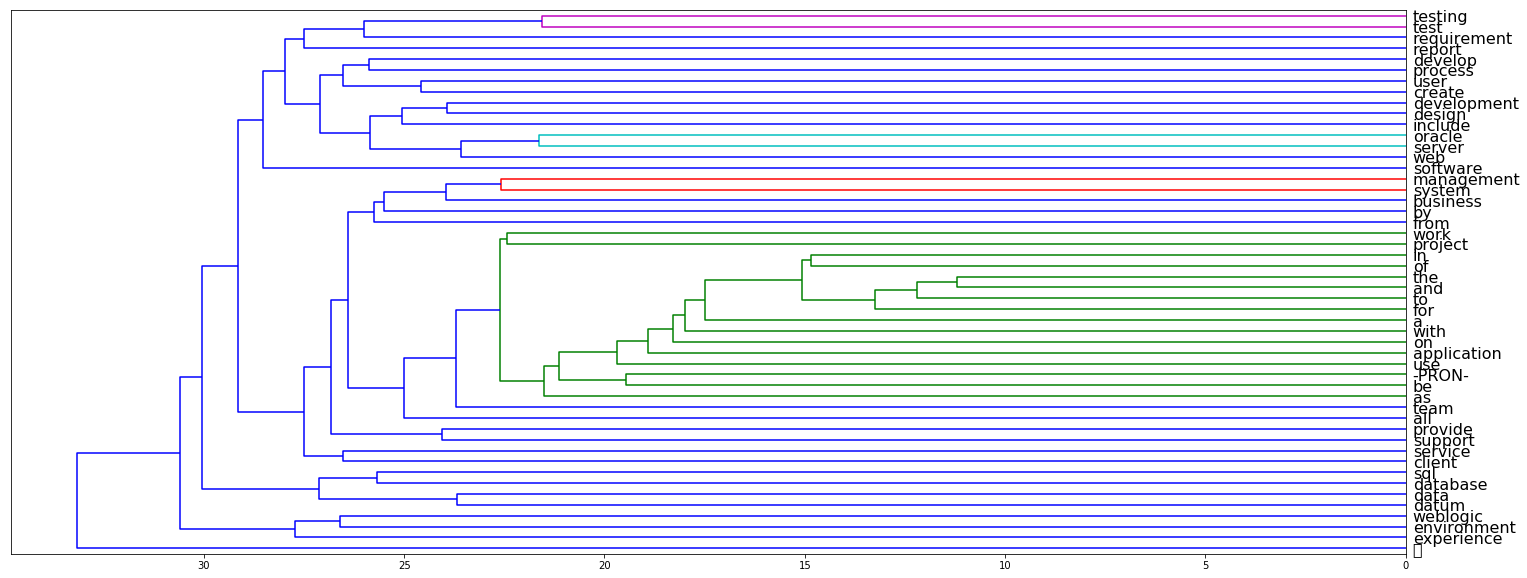

In [25]:
#this is another way to look at the data it put it into a tree with the closest things being leaves.  
#You can use this to potenially figure out categories
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

l=linkage(res2vec.wv.syn0[0:50],method='complete',metric='seuclidean')

plt.figure(figsize=(25,10))
dendrogram(
l,leaf_rotation=0,leaf_font_size=16,orientation='left',leaf_label_func=lambda v:str(res2vec.wv.index2word[v]))
plt.show()

Now that we have the word vectors we have to do something with them.  We can split them into k-means which means different sized clusters of data that groups together so we can see what rooms go together

In [26]:
from sklearn.cluster import KMeans


word_vector = res2vec.wv.syn0
print(int(word_vector.shape[0]/50))
num_clusters = int(word_vector.shape[0]/50)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vector )

111


In [27]:
#these are all the clusters created
word_centroid_map = dict(zip( res2vec.wv.index2word, idx ))
for cluster in range(0,num_clusters):
    #
    # Print the cluster number  
    print ("\nCluster:",cluster)
    #
    # Find all of the words for that cluster number, and print them out
    words = []
    for key,item in word_centroid_map.items():
        if( item == cluster ):
            words.append(key)
    print(words)


Cluster: 0
['ny', '1987', 'syracuse', 'la', 'georgia', 'newark', 'city', 'wayne', 'carolina', 'jersey', 'orleans', 'york', 'delaware', 'nj']

Cluster: 1
['intro', 'ic', 'intermediate', '3.00', 'english', '4.00', 'fluent', 'u', 'ex', 'd', '9.000', 'german', 'hindi', 'talk', 'l', 'o', 'ss', 'en', 'mandarin', 'calculus', 'cmsc', 'permanent', 'oo', 'ist', 'portuguese', 'spanish', 's', 'ctec', 't', 'er', 'discrete', 'compression', 'signal', 'engl', 'comp', '6.000', 'introduction', 'korean', '12.000', 'conversational', 'y', 'theory', '0.00', 'n', 'beginner', 'pcb', 'io', 'i', 'si', 'comm', 'id', 'b', 'f']

Cluster: 2
['also', 'of', 'business', 'develop', 'object', 'kranthikbheema@gmail.com', 'old', 'capability', 'evaluate', 'consistent', 'dynamic', 'standardize', '3.50', 'initiative', 'specific', 'enforce', 'apply', 'use', 'required', 'edit', 'record', 'enable', 'development', 'daily', 'external', 'introduce', 'set', 'design', 'customer', 'accord', 'document', 'create', 'replicate', 'includ

['natural', 'p.', 'k.', 'atlas', 'c.', 'integrated', 'j.', 'parallel', 'r.', 'pooma', 'workshop', 'news', 'm.', 'simulations', 'champion', 'intra', 'merit', 'w.', '1989', '1988', 's.', '1st', 'microcontroller', 'approach', 'devise', 'srikant', 'scientific', 'f.']

Cluster: 16
['satyam', 'cognizant', 'pvt', 'mahindra', 'ltd.', 'pune', 'wipro', 'infosys', 'hcl', 'tata', 'infotech', 'chennai', 'noida', 'limited', 'india', 'chandigarh', 'mumbai', 'accenture', 'maharashtra', 'hyderabad', 'bangalore', 'ltd']

Cluster: 17
['tie', 'adaptive', 'hyper', 'mf', 'premise', '6', 'converted', 'dmz', 'arm', 'resonate', 'centralized', 'advanced', 'series', 'thru', 'mode', 'couchbase', 'operating', 'dell', 'sw', 'environments', 'cobol', 'jcl', 'iv', 'vsphere', 'exchange', 'install', 'vault', 'django', '9', 'vmware', '2000/xp', 'internet', 'emc', 'heterogeneous', 'banyan', 'ccna', 'mcse', 'nextel', 'xp', 'certified', '2000/2003', 'distributed', 'mvs', 'virtualization', '64', 'certification', 'novell', 's

['inter']

Cluster: 44
['saas']

Cluster: 45
['fail']

Cluster: 46
['gm', '5.x', '4.x', 'detroit', 'mi']

Cluster: 47
['above', 'telecom', 'intern', 'previously', 'residency', 'hanover', 'rio', 'excellence', 'familiarize', 'fire', 'rebuild', 'educational', 'central', 'please', 'consultancy', 'recognition', 'employ', 'hewitt', 'supervised', 'dispatch', 'l.', 'centre', 'manager/', 'sergeant', 'assigned', '17', 'director', 'du', 'plc', 'controls', 'but', 'onsite', 'consulting', 'johnson', 'saba', '/contribution', 'building', 'administrative', 'name', 'what', 'nine', 'clinic', 'hopkins', 'supervisor', 'iii', 'nationwide', 'caci', 'specialize', 'last', 'instrumentation', 'forklift', 'say', '2014-december', 'soldier', 'eds', 'dr.', 'outsourced', 'paper', 'auxiliary', 'miller', 'williams', 'junior', 'since', '11/2013', '45', 'shore', 'leading', 'white', 'ops', 'middle', 'directors', 'baylor', 'technician', 'ufms', 'house', 'detector', 'geospatial', 'energy', 'contracting', 'canvasser', 'recog

['routers', 'ftp', 'switching', 'dns', 'ethernet', 'arp', 'ip', 'http', 'wins', 'cli', 'vpn', 'tcp', 'osi', 'routing', 'wan', 'telnet', 'dhcp', 'juniper', 'smtp', 'protocols', 'netware', 'nat', 'ospf', 'ipv4', 'igrp', 't3', 'bgp', 'https', 'vlan', 'atm', 'stp', 'l2/l3', 'ipv6', 'rip', 'eigrp', 'relay', 'lan', 'pop']

Cluster: 57
['contain']

Cluster: 58
['spml', 'disable', 'federated', 'kerberos', 'rules', 'saml', 'sign', 'single', 'directory', 'opensso', 'sailpoint', 'federation', 'workflows', 'provision', 'so', 'xpress', 'assertion', 'ldap', 'velocity', 'provisioning', 'rbac', '7.1', 'identity', 'sso', 'idm', 'authorization', 'terminate', 'roles', 'synchronization', 'authentication']

Cluster: 59
['making', 'decision']

Cluster: 60
['cassandra', 'hdfs', 'yarn', 'spark', 'hadoop', 'pig', 'hive', 'mapreduce', 'impala', 'sqoop']

Cluster: 61
['ie', 'compatibility', 'firefox', 'mozilla', 'edge', 'opera', 'explorer', 'chrome', 'browser', 'msie', '10/8/7', 'safari']

Cluster: 62
['quarter'

['side', 'box', 'distance', 'end', 'rout', 'multimedia', 'webex', 'navigation', 'seed', 'cod', 'coded', 'ui', 'mockup', 'publishing', 'apple', 'black', 'interfaces', 'gui', 'screen', 'demonstration', 'designing', 'wireframe', 'back', 'login', 'friendly', 'layout', 'instrument', 'front', 'backend', 'jeppesen', 'frontend', 'whole', 'page', 'panel', 'menu']

Cluster: 76
['station', 'rf', 'preliminary', 'cell', '30', 'gsm', 'wimax', 'cdma', 'simulate', 'pcs', 'd.c', 'coverage', 'surround', 'metro', '\xad', '25', 'downlink', 'carrier', 'ericsson', 'downtown', '1c', 'antenna', 'lte', 'minimum', 'nearby', 'stations', 'umts', 'microwave', 'channel', '3-sectored', 'road', 'wave', 'shadow', 'cellular', 'suburb', 'mock', 'wcdma', 'radio', 'tilt']

Cluster: 77
['irs', 'resident', 'attain', 'tax', 'license', 'preparer']

Cluster: 78
['ivr', 'centric', 'completely', 'rpm', 'poi', 'strict', 'adoption', 'downstream', 'combination', 'forth', 'cas', 'ods', 'main', 'theme', 'could', 'allocation', 'output

['abstract', 'factory', 'patterns', 'structural', 'pattern', 'di', 'dao', 'singleton']

Cluster: 104
['third', 'party']

Cluster: 105
['idea']

Cluster: 106
['disaster', 'exadata', 'crp', 'horizontal', 'msrb', 'caching', 'clusters', 'continuity', 'rman', 'tb', 'replication', 'snapshot', 'rac', 'goldengate', 'clone', 'hot', 'asm', 'stack', 'automatic', 'restore', 'optimal', 'standby', 'vertical', 'epic', 'offsite', 'backup', 'appliance', 'storage', 'updates', 'recovery', 'cold', 'cloning', 'guard', 'recover']

Cluster: 107
['simple']

Cluster: 108
['~']

Cluster: 109
['background']

Cluster: 110
['1.6', '1.5']


In [28]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(list(word2vec.values())[0])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

We are now going to use the wordvectors and k means to predict whether a word based on its vector is a skill or not

In [29]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np

w2v = dict(zip(res2vec.wv.index2word, res2vec.wv.syn0))

etree_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])
svm_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("SVM", SVC())])

print(svm_w2v)
print(etree_w2v)

Pipeline(steps=[('word2vec vectorizer', <__main__.MeanEmbeddingVectorizer object at 0x7f493aec55c0>), ('SVM', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Pipeline(steps=[('word2vec vectorizer', <__main__.MeanEmbeddingVectorizer object at 0x7f493aec5ba8>), ('extra trees', ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])


In [30]:
#you can see that its not entirely accurate and when we have a higher base of resumes might work a lot better
X=[['python','ocaml'],
  ['economics','sociology'],
  ['css','javascript']]
y=['scripting','majors','web']
etree_w2v.fit(X,y)
test_X=[['perl'],['psychology'],['asp.net']]
print(etree_w2v.predict(test_X))


['web' 'majors' 'web']


I now test this on a real resume by getting the clusters with the most skills from a list we compiled.  We will then enter that into one of the fitting algorithms to test its accuracy

In [31]:
#loading skills into a dataframe
df_skill = pd.read_excel('Skills.xlsx',columns='Skills')
print(df_skill.head(),'\n')
skill_series = df_skill.T.squeeze().str.lower()
print(skill_series)

  Skill Names
0        .Net
1   · iKeyman
2       @Risk
3        ABAP
4         ACL 

0                               .net
1                          · ikeyman
2                              @risk
3                               abap
4                                acl
5                            acrobat
6                       active batch
7                   active directory
8                              adapt
9                          adaptable
10                 adobe acrobat pro
11                       adobe flash
12                 adobe illustrator
13                   adobe photoshop
14                    advanced excel
15                               aes
16                             agile
17               agile methodologies
18                 agile methodology
19                               aix
20                              ajax
21             alm hp quality center
22                           altiris
23               amazon web services
24                        

In [32]:
#create a dictionary 
d = {}
import operator
#go through each cluster and add the cluster and number of skills it has in it
for cluster in range(0,num_clusters):
    #
    # Print the cluster number  
    #
    # Find all of the words for that cluster number, and print them out
    words = []
    for key,item in word_centroid_map.items():
        if( item == cluster ):
            words.append(key)
    cluster_series = pd.Series(words)  
    temp = pd.Series(list(set(cluster_series)&(set(skill_series))))
    d[cluster] = len(temp.values)
#sort the dictionary so the ones with the most skills are at the top    
sorted_d = list(reversed(sorted(d.items(),key=operator.itemgetter(1))))
print(sorted_d)
print(sorted_d[1])
top_ten_skills = []
#get the top 3 clusters
for i in range(0,3):
    key,val = sorted_d[i]
    top_ten_skills.append(key)
top_ten_skills = pd.Series(top_ten_skills)    
print(top_ten_skills)    

[(14, 48), (48, 31), (5, 30), (56, 24), (2, 22), (94, 17), (49, 16), (17, 16), (28, 15), (7, 14), (82, 13), (27, 13), (96, 12), (10, 12), (87, 9), (33, 9), (93, 8), (52, 8), (91, 7), (76, 6), (67, 6), (21, 6), (92, 5), (83, 5), (60, 5), (20, 5), (58, 4), (38, 4), (3, 4), (69, 3), (54, 3), (47, 3), (12, 3), (4, 3), (100, 2), (85, 2), (78, 2), (50, 2), (6, 2), (102, 1), (89, 1), (75, 1), (72, 1), (64, 1), (63, 1), (44, 1), (42, 1), (40, 1), (39, 1), (37, 1), (36, 1), (30, 1), (23, 1), (13, 1), (8, 1), (110, 0), (109, 0), (108, 0), (107, 0), (106, 0), (105, 0), (104, 0), (103, 0), (101, 0), (99, 0), (98, 0), (97, 0), (95, 0), (90, 0), (88, 0), (86, 0), (84, 0), (81, 0), (80, 0), (79, 0), (77, 0), (74, 0), (73, 0), (71, 0), (70, 0), (68, 0), (66, 0), (65, 0), (62, 0), (61, 0), (59, 0), (57, 0), (55, 0), (53, 0), (51, 0), (46, 0), (45, 0), (43, 0), (41, 0), (35, 0), (34, 0), (32, 0), (31, 0), (29, 0), (26, 0), (25, 0), (24, 0), (22, 0), (19, 0), (18, 0), (16, 0), (15, 0), (11, 0), (9, 0), (

I only did three because it was overfitting to skills using 10 so I found 3 at least had some things show as other

In [33]:
skills = []
other = []
for cluster in range(0,num_clusters):
    #
    # Print the cluster number  
    #
    # Find all of the words for that cluster number, and print them out
    #get the words in skills
    if top_ten_skills.isin([cluster]).any():
        for key,item in word_centroid_map.items():
            if(item == cluster):
                skills.append(key)
    #get all other words            
    else:
        for key,item in word_centroid_map.items():
            if(item == cluster):
                other.append(key)    
                             

In [34]:
len(skills)

232

In [35]:
len(other)

5337

In [36]:
#just testing to see accuracy
X = [skills,other]
y=['skills','other']
etree_w2v.fit(X,y)
test_X = [['perl'],['ruby'],['university']]
print(etree_w2v.predict(test_X))
svm_w2v.fit(X,y)
print(svm_w2v.predict(test_X))

['skills' 'skills' 'other']
['skills' 'skills' 'other']


In [37]:
#load my test resume
test_resume = """Jee Won Kang \n
3711 Campus Drive APT 139 College Park, MD \n
4439447487 | jwk1151@gmail.com \n

EDUCATION \n
University of Maryland College Park (Dual Degree) \n
Cumulative GPA: 3.7 \n
Anticipated Fall 2018 \n
• B.S. Physiology and Neurobiology \n
• B.S. in Computer Science \n
Relevant Courses: \n
• Object Oriented Programming I & II, Introduction to Computer Systems, Discrete Structures, \n
How Do Innovators Think? \n
\n
Languages and Technologies \n
§ Languages: Java, C \n
§ Programs: Eclipse, Android Studio, MATLAB, LaTeX, LabChart \n
\n
Projects \n
Projects can be found at my github: github.com/jeekang \n
Turnt Tower (2016): \n
• Independently developed an android app to augment the block tower game, Jenga. \n
• App features an attractive, user-friendly interface. \n
• Language: Java, Android \n
Java-Based DNA template strand Transcription/Translation (2016): \n
• Built a program using Java that takes an input nucleotide sequence and returns the \n
complementary strand, mRNA sequence, reading frame (if one exists) and amino acid sequence. \n
Independent Undergraduate Research Project (2016): \n
• Part of the Center for Bioinformatics and Computational Biology at the University of Maryland. \n
• Working with meta-genomic analysis algorithms and finding limitations of existing programs. \n
• Details to be determined, first meeting with team on September 21st \n
\n
Achievements \n
§\n
§\n
§\n
§\n
\n
Received Integrated Life Sciences Honors College Citation (2014) \n
Received Presidential Scholarship at the University of Maryland (Fall 2012 – Spring 2016) \n
Scored in the 94th percentile in the MCATs (Jan 2015) \n
6 semesters on the Dean’s List \n 
\n
Experience \n
Affective and Translational Neuroscience Laboratory \n
College Park, MD \n
Research Assistant \n
Fall 2013- Spring 2015 \n
• Brainstormed ideas for trial stages such as how to track social habits/movements of subjects. \n
• Front-end experience: briefed and debriefed study participants. \n
• Worked with the psychology clinic at University of Maryland using Titanium and Excel to manage \n
patient DSM-5 data. \n
• Assisted in running clinical trials involving the fMRI at Maryland Neuroimaging Center."""

In [38]:
#do a bit of standardizing
test_resume = test_resume.replace('\n','').lower()
print(test_resume)

jee won kang 3711 campus drive apt 139 college park, md 4439447487 | jwk1151@gmail.com education university of maryland college park (dual degree) cumulative gpa: 3.7 anticipated fall 2018 • b.s. physiology and neurobiology • b.s. in computer science relevant courses: • object oriented programming i & ii, introduction to computer systems, discrete structures, how do innovators think? languages and technologies § languages: java, c § programs: eclipse, android studio, matlab, latex, labchart projects projects can be found at my github: github.com/jeekang turnt tower (2016): • independently developed an android app to augment the block tower game, jenga. • app features an attractive, user-friendly interface. • language: java, android java-based dna template strand transcription/translation (2016): • built a program using java that takes an input nucleotide sequence and returns the complementary strand, mrna sequence, reading frame (if one exists) and amino acid sequence. independent unde

In [39]:
#turn each word into its own array in a 2d array so we can input it into the algrorithims
test_res_arr = test_resume.split()
test_X = []
for word in test_res_arr:
    test_X.append([word])
test_X

[['jee'],
 ['won'],
 ['kang'],
 ['3711'],
 ['campus'],
 ['drive'],
 ['apt'],
 ['139'],
 ['college'],
 ['park,'],
 ['md'],
 ['4439447487'],
 ['|'],
 ['jwk1151@gmail.com'],
 ['education'],
 ['university'],
 ['of'],
 ['maryland'],
 ['college'],
 ['park'],
 ['(dual'],
 ['degree)'],
 ['cumulative'],
 ['gpa:'],
 ['3.7'],
 ['anticipated'],
 ['fall'],
 ['2018'],
 ['•'],
 ['b.s.'],
 ['physiology'],
 ['and'],
 ['neurobiology'],
 ['•'],
 ['b.s.'],
 ['in'],
 ['computer'],
 ['science'],
 ['relevant'],
 ['courses:'],
 ['•'],
 ['object'],
 ['oriented'],
 ['programming'],
 ['i'],
 ['&'],
 ['ii,'],
 ['introduction'],
 ['to'],
 ['computer'],
 ['systems,'],
 ['discrete'],
 ['structures,'],
 ['how'],
 ['do'],
 ['innovators'],
 ['think?'],
 ['languages'],
 ['and'],
 ['technologies'],
 ['§'],
 ['languages:'],
 ['java,'],
 ['c'],
 ['§'],
 ['programs:'],
 ['eclipse,'],
 ['android'],
 ['studio,'],
 ['matlab,'],
 ['latex,'],
 ['labchart'],
 ['projects'],
 ['projects'],
 ['can'],
 ['be'],
 ['found'],
 ['at'],
 [

In [40]:
#predict whether the work is a skill or not
predict = svm_w2v.predict(test_X)
for i in range(0,len(predict)):
    print(test_X[i],predict[i])

['jee'] skills
['won'] other
['kang'] other
['3711'] other
['campus'] other
['drive'] other
['apt'] other
['139'] other
['college'] other
['park,'] other
['md'] other
['4439447487'] other
['|'] skills
['jwk1151@gmail.com'] other
['education'] other
['university'] other
['of'] other
['maryland'] other
['college'] other
['park'] other
['(dual'] other
['degree)'] other
['cumulative'] other
['gpa:'] other
['3.7'] skills
['anticipated'] other
['fall'] other
['2018'] other
['•'] other
['b.s.'] other
['physiology'] other
['and'] other
['neurobiology'] other
['•'] other
['b.s.'] other
['in'] other
['computer'] other
['science'] other
['relevant'] other
['courses:'] other
['•'] other
['object'] other
['oriented'] other
['programming'] skills
['i'] other
['&'] other
['ii,'] other
['introduction'] other
['to'] other
['computer'] other
['systems,'] other
['discrete'] other
['structures,'] other
['how'] other
['do'] other
['innovators'] other
['think?'] other
['languages'] skills
['and'] other
['te

This doesn't work that great and im not sure if its because its the wrong approach or just not engough data to support something like this.  It might be worth re exploring this when there are more resumes to build a word2vec model

In [41]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(word_vector)
distances, indices = nbrs.kneighbors(word_vector)


In [42]:
res2vec.wv.doesnt_match('python java css html university'.split())

'university'

I now am ttying doc2vec which could allow us to match resumes as a whole not just as individual pieces to perform who the most similar person to a specific employee

In [43]:
#open the file and make it an array of resumes
stri = ''
with codecs.open(resume_text,encoding="utf_8") as f:
    for line in f:
        stri = stri+line
        
resumes = stri.split('\\n')
resumes[100]

'\nPRASAD KAVERI\n3412 University Boulevard East, Hyattsville, MD 20783\nContact No.: 301-273-4187 || Email ID: prasadkaveri9@gmail.com || https://www.linkedin.com/in/prasadkaveri\nEDUCATION\nUniversity of Maryland, College Park\nDec 17\nMaster of Science, Telecommunications Engineering\nGPA: 4.0/4.0\nTechnical Coursework: Network Programming, Network and Protocols, Cyber Security, Cellular Communication Networks\nManagement Coursework: Economics of telecommunications, Strategic Management in Telecommunications\nUniversity of Mumbai, India\nJune 15\nBachelor of Engineering, Electronics and Telecommunications Engineering\nRelated Coursework: Computer Communication Networks, Data Compression & Encryption, Java, C, Mobile Comm., Wireless\nNetworks, Digital Communication\nTECHNICAL SKILLS\nTools & Software: Drupal CMS, Quality Center, Jira, Eclipse, Visual Studio, MATLAB, WinAVR, Eagle software\nProgramming & Computer Skills: Python, Java, C, HTML, Microsoft office Suite, Assembly Language

In [44]:
#here i standardize the resumes by getting rid of formatting and special characters and then use first 15 characters
#as the name of the document
from nltk.corpus import stopwords
from gensim.models.doc2vec import LabeledSentence

resumes_normal = []

special_characters = ['!','#', '$', '%','&','*','-', '/', '=','?',
                      '^','.','_','`', '{', '|', '}','~', "'", ',', '@', '(',')', ':', '•', '§','','\x0c','\t','',
                     '♦']

for res in resumes:
    res_norm = res.lower()
    for spec in special_characters:
        res_norm=res_norm.replace(spec,'')
    res_norm = res_norm.replace('\n',' ')
    res_arr = res_norm.split(' ')
    res_arr = list(filter(lambda x : x != '', res_arr))
    resumes_normal.append(LabeledSentence(words=res_arr,tags=[res_norm[0:15]]))
    print(res_norm[0:15])
print(len(resumes_normal))
#for i in range(0,15):
    #print(resumes_normal[i])
    #print('\n\n\n')

jee won kang 37
 yaw owusu appi
 dimitri  richa
 3412 tulane dr
 kane baccigalu
 nirali deliwal
 muhammad afola
 terence mcpart
 joseph man    
 tejal rikame  
 aakash desai 8
 debi luff  682
 prasad kaveri 
 lakhan abichan
 vanya dasari  
 naveen gupta  
 bobbie bass  c
 ‍‍julianah ale
   merinajoy 50
 rajan subraman
 justin omps  1
 tywan j mcdani
 tammi kyle    
 jaspreet singh
 diane thomas  
 volodymyr mayb
 kyle martin  8
 joseph cristia
 ishmeet singh 
 samyak shah 34
 arpit kapoor 8
 binod kumar si
 keerthi gadira
 jared smith di
 mary curto man
 pallavi kambir
 ethan r ace  7
 navdeep singh 
 jeekang contac
 john park 1452
 kranthi bheema
 nigel wheeler 
 yeshwanth sing
 kingue menvout
 gaurav hegde 4
 091115     kev
 842016unoffici
 kaushalchandra
 kanti bhojani 
 sandesh shanta
 samantha leap 
 liudmila bolat
 muhammad afola
 raymond e geor
 abdur rehman b
 kulvinder b ka
 an integration
 anshita jain 6
 tewodros e men
 310passaicave 
 linda larsen  
 igor spektor m
 manmoha

In [45]:
#make the doc2vec model its the same as word2vec
from gensim.models import Doc2Vec

if 1==1:
    model = Doc2Vec(min_count=1, window=10, size=200, sample=1e-4, negative=5, workers=8)
    model.build_vocab(resumes_normal)
    for epoch in range(10):
        model.train(resumes_normal,total_examples=model.corpus_count, epochs=model.iter)
        model.alpha -= 0.002  # decrease the learning rate
        model.min_alpha = model.alpha  # fix the learning rate, no decay
    model.save('doc2vec_model.doc2vec')    

In [46]:
model_loaded = Doc2Vec.load('doc2vec_model.doc2vec')
model_loaded

In [47]:
#same as word2vec but gets closest documents
def get_related_documents(token,topn=10):
    "get the top n most similar terms"
    for word,similar in model_loaded.wv.most_similar(positive = [token],topn=topn):
        print(word,':',round(similar,3))

In [48]:
model_loaded.docvecs.most_similar(' henry hung dao')

[(' rujun dai 3300', 0.7136235237121582),
 (' xinhui du 9530', 0.6320823431015015),
 (' gaurav hegde 4', 0.6293470859527588),
 (' yang yang 9530', 0.6269785165786743),
 ('releases for sh', 0.6245165467262268),
 (' developed juin', 0.6183342933654785),
 (' wenqi yang 912', 0.6179338693618774),
 ('noah parker wv', 0.6169958710670471),
 (' analyzed and r', 0.6137088537216187),
 ('analytical skil', 0.6074315309524536)]

In [49]:
model_loaded.docvecs.doctags
#for i in range(0,10):
 #   print(model_loaded.docvecs.index_to_doctag(i),model_loaded.docvecs[i][0:10])

{'': Doctag(offset=113, word_count=0, doc_count=146),
 ' ': Doctag(offset=176, word_count=0, doc_count=18),
 '   merinajoy 50': Doctag(offset=18, word_count=187, doc_count=1),
 ' 091115     kev': Doctag(offset=45, word_count=1517, doc_count=1),
 ' 2  experience ': Doctag(offset=404, word_count=689, doc_count=1),
 ' 3012570493  ma': Doctag(offset=256, word_count=812, doc_count=1),
 ' 310passaicave ': Doctag(offset=58, word_count=43, doc_count=1),
 ' 3412 tulane dr': Doctag(offset=3, word_count=422, doc_count=1),
 ' 4318 101 rowal': Doctag(offset=78, word_count=1100, doc_count=2),
 ' 5133569626  ji': Doctag(offset=567, word_count=545, doc_count=1),
 ' 842016unoffici': Doctag(offset=46, word_count=829, doc_count=1),
 ' aakanksha jain': Doctag(offset=390, word_count=662, doc_count=1),
 ' aakash desai 8': Doctag(offset=10, word_count=530, doc_count=1),
 ' aanchal kanodi': Doctag(offset=138, word_count=436, doc_count=1),
 ' abbas roshan 8': Doctag(offset=276, word_count=13483, doc_count=1),


In [50]:
ordered = [(term,voc.index,voc.count)for term, voc in model_loaded.wv.vocab.items()]
ordered_terms,term_indices,term_count = zip(*ordered)
word_vectors = pd.DataFrame(model_loaded.wv.syn0[term_indices,:],index=ordered_terms)
word_vectors.head()


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
realm,0.133448,-0.307246,0.089115,0.571310,-0.058369,-0.459833,0.316774,-0.483032,0.164023,-0.459875,...,-0.223601,-0.433146,0.373684,0.386468,-0.228649,-0.116825,0.100805,0.061040,-0.124982,0.340035
conflicts,-0.115950,0.069740,0.259663,0.161580,-0.284555,-0.012592,-0.132060,0.105753,0.521646,0.199672,...,-0.051682,0.056280,0.479408,-0.372514,0.068880,-0.303948,0.164276,0.039017,-0.284488,0.132549
baggage,-0.021055,-0.240124,0.219496,-0.184015,0.059679,-0.024545,0.154087,-0.082183,-0.075080,0.159508,...,-0.010499,-0.000650,0.047222,-0.235306,-0.068773,-0.078483,0.014644,-0.109209,-0.186566,0.039950
yoruba],0.029950,0.261112,0.043937,-0.178396,0.201040,0.001688,-0.003010,0.117020,0.428644,0.165765,...,-0.374742,0.139788,0.087364,-0.112583,-0.296623,0.134028,0.208480,0.095837,-0.064533,0.030531
benthic,0.086430,0.648419,-0.447333,-0.058049,0.212265,0.107617,0.250785,-0.105286,0.045523,-0.452046,...,-0.174751,0.239216,-0.095435,-0.144675,-0.261833,0.173363,-0.262669,-0.050713,0.148905,-0.167417
